In [40]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root
from numpy.random import normal as norm

In [2]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar
    
eta = 0.1
Ncut = 1000
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [3]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(nbar): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

In [4]:
def rhoee(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,1]))**2.0
    return result

def rhogg(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,0]))**2.0
    return result

def psi(g,e):
    return np.array([g, e])

def groundPsi(Ncut):
    result = np.zeros((Ncut,2),dtype="complex")
    result[:,0] = 1.
    return result

def subPulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def pulse(psi, t, Omega0, delta, phi0, phi1):
    Ncut = np.shape(psi)[0]
    result = np.zeros((Ncut,2),dtype="complex")
    if (Omega0==0):
        subpulse = subPulse(t, Omega0, delta, phi0, phi1)
        for n in range(Ncut):
            result[n,:] = subpulse@psi[n,:]
    else:
        for n in range(Ncut):
            result[n,:] = subPulse(t, Omega0*omegas[n], delta, phi0, phi1)@psi[n,:]
    return result

In [5]:
def HR(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJump(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(pulse(psiP, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(pulse(psiM, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJumpFront(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(2.0*t1/3.0, -Omega0, delp1, 0.0, 0.0)@subPulse(t1/3.0, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

In [26]:
def shiftCurve(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    #guessTol = 2.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = [None]*pts
    for ii in range(pts):
        print(nbarfs[ii])
        x0 = -np.pi/T+0.1
        x1 = np.pi/T-0.1
        bounds = list(np.linspace(x0+1.0,x1-1.0,25))
        while (shifts[ii] is None) and (bounds != []):
            try:
                print("bounds:",[x0,x1])
                shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
                print("shift:",shifts[ii])
                print("")
            except:
                print("except")
                guess = bounds.pop(np.random.randint(np.size(bounds)))
                x0 = guess-1.0
                x1 = guess+1.0
    return np.array(shifts)

In [45]:
delp = 2.0*np.pi*0.0
nbarfPts = 500
np.random.seed(10)
nbarfs = np.zeros(nbarfPts)
for n in range(nbarfPts):
    nbarfs[n] = np.random.uniform(53,59)
results = np.zeros(nbarfPts)

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300


results = shiftCurve(HR, t1, T, t2, delp, delp, Omega0, nbarfs, Ncut)

57.62792385960048
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.235111925107915

53.12451169615641
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: -0.1323404180409171

56.80188940955765
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-1.780997959330497, 0.21

except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-1.0, 1.0]
shift: 0.30427979243507763

56.25526620806757
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-1.0, 1.0]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [1.3429938779914945, 3.3429938779914945]
shift: 1.8266443571625914

53.85302028560916
bounds: [-10.371975511

shift: -9.932528737348001

56.28551693551546
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
shift: 1.6100026656665922

57.915721974020414
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: 0.19916755506082245

54.193685238072874
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.20541673865821108

58.1411018147464
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-1.0, 1.0]
shift: 0.1769261027527315

55.10991583659253
bounds: [-10.3719

except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.277248858649509

54.508244805242356
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-10.371975511965978, -8.371975511965978]
except


shift: 0.24461892580772748

58.26857985634915
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.16635530065717352

55.5050548630356
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.6640743153027193

56.63346538636254
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.6567259290333168

56.08079976444973
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.34299387799

except
bounds: [-1.0, 1.0]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-8.028981633974484, -6.0289816339744835]
shift: -6.589641493245289

56.468818579294805
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [0.5619959186609975, 2.5619959186609975]
shift: 0.9182275454122033

58.12360250300292
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [3.685987755982989, 5.685987755982989]


shift: -0.43233141852303636

54.31261609507722
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: -0.2190044747227554

57.514977021311616
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.2557320185619497

53.64127750636141
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.15967023434913363

57.467619444653366
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.90498

except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-1.0, 1.0]
shift: 0.16671300991076213

56.505174971184054
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -9.627487485760795

57.2530989582

except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.207731986675086

56.34377243741838
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -9.167903725051664

55.31068159739292
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-1.0, 1.0]
shift: -0.4981678238089517

54.00843678519571
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.28461672008978

58.02956792422216
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [6.028981633974485

shift: -0.155109268092907

57.294985236507884
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-1.0, 1.0]
shift: 0.30238693437530756

53.46251242649623
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-1.780997959330497, 0.2190020406695030

shift: 0.1330972717612314

54.90200937383473
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.14516959824411

58.1933157093637
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-1.0, 1.0]
shift: 0.17244371542612819

54.861702241640714
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [0.561

except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.40627185558829987

57.765854370959204
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.254765386255485

58.0677131668631
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.18362026097769937

56.228885102839754
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865

shift: 0.1978943104151062

54.7295188327533
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.18645018579131

54.648770789556615
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.20235885047401

56.60631134679506
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -9.78266566439524

58.631085183256026
bo

except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-1.0, 1.0]
shift: 0.19360140657399746

58.783403137029694
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: 0.13372554706545495

56.593618694436046
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [0.5619959186609975, 2.5619959186609975]
shift: 0.7056496909333152

58.58549501508651
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-0.21900204066950124, 1.7809

except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.164408897140161

56.50433523533162
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.84606099

shift: -0.1450428645946273

55.071420739171145
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.38106281021778454

53.12257981286897
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [7.590977

shift: 4.35527872548178

56.75686201475854
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.5401174

shift: -0.22428365084669724

53.792330763631924
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.16998665925400427

58.44525767909631
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.31840388146216

58.46138381995858
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-9.59097755263548, -7.59

except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-1.0, 1.0]
shift: 0.3394808084551288

57.309423081917885
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.17315389379672

57.53829414737359
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [2.904989796652492, 4.904989796652492]
exc

shift: 10.292948845963378

53.20341507879537
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.13587945517755148

58.89100914852727
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: 0.12840281726785988

55.16291186092435
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.05330689669003

57.9527871713721
bounds: [-10.371975511965978, 10.371975511965978]
excep

except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.214537161524607

56.160999329222456
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-1.0, 1.0]
except
bounds: [-8.028981633974484, -6.0289816339744835]
shift: -7.4918784006315455

57.708431484562844
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [7.590977552635479, 9.59097755263548]
exce

shift: 0.1283545627605973

57.289927735071956
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-1.0, 1.0]
shift: 0.30365562268904345

53.05195562850375
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.12924834601888174

54.728873485962865
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-0.21

shift: 10.344426106117279

58.802274519380305
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.13276193271432296

57.847199199590555
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [6.8099795933

shift: 10.239289980218524

53.538869834379355
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-1.0, 1.0]
shift: -0.15337291323464322

54.16686904593223
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.20258633396930742

56.6948472522027
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [

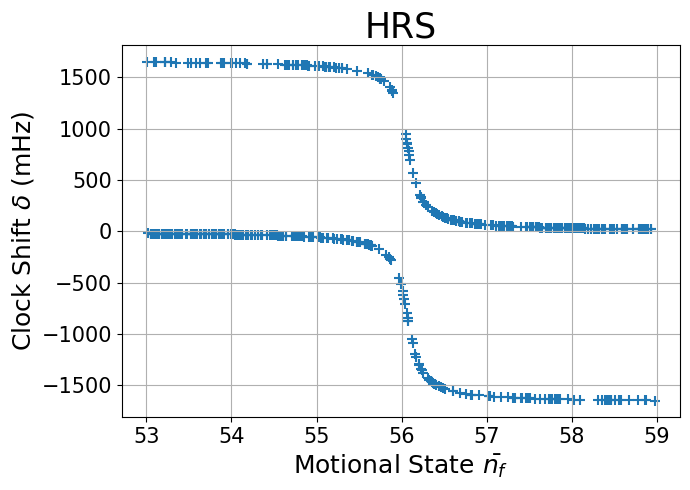

In [46]:
plt.figure(figsize=(7,5), dpi=100)
plt.scatter(nbarfs, results*1e3/(2.0*np.pi),marker="+",s=50)
plt.title("HRS",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
#plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
#plt.xlim([0,58])
#plt.ylim([-100,0])
plt.show()

In [48]:
def HRNoise(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, norm(Omega0, 0.005*Omega0), delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,norm(np.pi/2., 0.005*np.pi))@intState 
    intStateM = subPulse(0.,0.,0.,0.,norm(-np.pi/2., 0.005*np.pi))@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, norm(Omega0, 0.005*Omega0), delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, norm(Omega0, 0.005*Omega0), delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

In [49]:
delp = 2.0*np.pi*0.0
nbarfPts = 500
np.random.seed(10)
nbarfs = np.zeros(nbarfPts)
for n in range(nbarfPts):
    nbarfs[n] = np.random.uniform(53,59)
results = np.zeros(nbarfPts)

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300


results = shiftCurve(HRNoise, t1, T, t2, delp, delp, Omega0, nbarfs, Ncut)

57.62792385960048
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.3683017000411092

53.12451169615641
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [2.1239918373219933, 4.123991837321993]
exce

shift: 2.1281842566724523

53.85302028560916
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-1.0, 1.0]
shift: -0.17144715742528077

55.24004456030882
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-1.0, 1.0]
shift: -0.46353074867766264

57.044801690398074
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [7.590977552635479, 9.59097755263548]
shift: 7.626981179179801

55.650999046537976
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [6.028981633974485, 8.028981633974485]
shift: 

except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-1.0, 1.0]
shift: 0.15755168766955466

54.95306982699349
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [6.809979593304984, 8.809979593304984]
shift: 8.80966663052396

53.99009538631489
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-1.0, 1.0]
shift: -0.1776030259947317

55.35517546367952
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [6.809979593304984, 8.809979593304984

except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.3328183235885796

53.239755252139865
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.11961534049306724

55.57695307058983
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 9.793351713542169

54.88956123105613
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-7.247983674643985,

shift: -5.685987755982989

55.97029178529473
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-8.80997959330498, -6.809979593304981]
shift: -7.45477186247365

58.86248435553609
bounds: [-10.371975511965978, 10.371975511965978]
shift: 0.1523292251520904

55.644642949404
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
shift: 7.7457017668145225

54.90963683287371
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.13687175453757

56.11878191525228
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-6.466985715313

except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.19311448751383775

54.104208932558905
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [4.466985715313488, 6.466985715313488]
exce

shift: 10.275760733874542

55.637631426647545
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-8.028981633974484, -6.0289816339744835]
shift: -8.028980576629259

53.9972128862272
bounds: [-10.371975511965978, 10.371975511965978]
shift: -0.6011145125552013

56.04187177558428
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [5.2479836746439865, 7.2479836746439865]
shift: 6.200955052723259

57.91421518481727
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: 0.18227777967640824

53.54064040834663
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.809979593304984, 8.8099795933049

except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-1.0, 1.0]
shift: 0.19821418490170195

54.048883368932714
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.2606711552402

53.0878092506195
bounds: [-10.371975511965978, 10.371975511965978]
except

except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.33539696409310593

57.97641151896342
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-1.0, 1.0]
shift: 0.17062878952222685

57.41829622303138
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-1.0, 1.0]
shift: 0.2441558414145227

56.04560544832976
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-0.21900204066950124, 1.78099

except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.17402081173135478

54.64576891409238
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-1.0, 1.0]
shift: -0.3122971266126948

57.25463578443194
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-9.59097755263548, -7.590977552635479]
shift: -7.592177241316544

55.13463405694198
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-6

except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.199736675442862

54.7295188327533
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.2486362630288621

54.648770789556615
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.2188390516421289

56.60631134679506
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
shift: 8.028967020272757

58.631085183256026
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.318323552588625

57.243777856048624
bounds: [-1

shift: -0.23494573392740126

55.23217341304301
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: -0.5535142079265012

57.59936075942544
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.245242118184727

54.92685218878976
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: 

shift: 10.14284289460521

57.1506476454588
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: 0.21900204066950302

54.13417671713381
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: -0.2240753003053671

57.818045220301386
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: 0.10951309356722348

56.08858249914028
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -8.374728727943529

57.54371624189369
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-2.5619959186609957, -0.5619959186609957]
except
bounds: [0.5619959186609975, 2.561995918660

shift: 10.28704164694616

57.19936390717552
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [1.3429938779914945, 3.3429938779914945]
shift: 3.3429938779914945

53.34769883606033
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [1.3429938779914945, 3.3429938779914945]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.17852104148894798

54.53964540109398
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [2.1239918373219933, 4.123991837321993]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [-7.247983674643985, -5.2479836746

shift: 0.8560464184028911

58.6140200119739
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-8.80997959330498, -6.809979593304981]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-10.3

shift: 0.2785860038738205

55.644422344482805
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [2.904989796652492, 4.904989796652492]
shift: 4.9049785547305245

57.16242418557147
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [2.904989796652492, 4.904989796652492]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [1.3429938779914945, 3.3429938779914945]
shift: 1.366360581032925

57.309423081917885
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-8.028981633974484, -6.0289816339744835]
shift: -6.0300115850416525

57.53829414737359

except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.1659823541657994

57.638693595660285
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-3.3429938779914945, -1.3429938779914945]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.2903858698628

57.027541430753786
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.170762388823135

57.237985311204
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [6.809979593304984, 8.809979593304984]
shift: 6.809979593304984

58.118932479142416
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-1.0, 1.0]
shift: 0.16657217435836957

56.13229

shift: 0.5972481859992493

56.021448438303985
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-5.685987755982989, -3.685987755982989]
shift: -4.882403949136331

58.793316293730776
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [7.590977552635479, 9.59097755263548]
except
bounds: [-7.247983674643985, -5.247983674643985]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-1.0, 1.0]
shift: 0.1342796418117413

57.84014689766294
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.123991837321992, -2.1239918373219924]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: 0.24540405284727776

58.5711161384217
bounds: [-10.371975511965978,

except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [6.028981633974485, 8.028981633974485]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-10.371975511965978, -8.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
shift: 10.268330534622644

53.01055789462616
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [0.5619959186609975, 2.5619959186609975]
except
bounds: [-9.59097755263548, -7.590977552635479]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [3.685987755982989, 5.685987755982989]
except
bounds: [6.809979593304984, 8.809979593304984]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-0.21900204066950124, 1.7809979593304988]
shift: -0.13645266834999922

58.802274519380305
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
except
bounds: [-5.685987755982989, -3.685987755982989]
except
bounds: [-8.0289816339744

shift: -9.59097755263548

57.272187118322975
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [8.371975511965978, 10.371975511965978]
except
bounds: [-1.780997959330497, 0.21900204066950302]
except
bounds: [-6.466985715313487, -4.466985715313487]
except
bounds: [-10.371975511965978, -8.371975511965978]
shift: -10.249624221092096

54.844276511224784
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [2.904989796652492, 4.904989796652492]
shift: 4.904989796652492

55.122707328625935
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [5.2479836746439865, 7.2479836746439865]
shift: 5.2479836746439865

54.41812037134267
bounds: [-10.371975511965978, 10.371975511965978]
except
bounds: [-4.90498979665249, -2.9049897966524902]
except
bounds: [-8.028981633974484, -6.0289816339744835]
except
bounds: [4.466985715313488, 6.466985715313488]
except
bounds: [-1.780997959330497, 0.21900204066950302]
shift: -0.26611242309172245

53.538869834379355
bounds: [-1

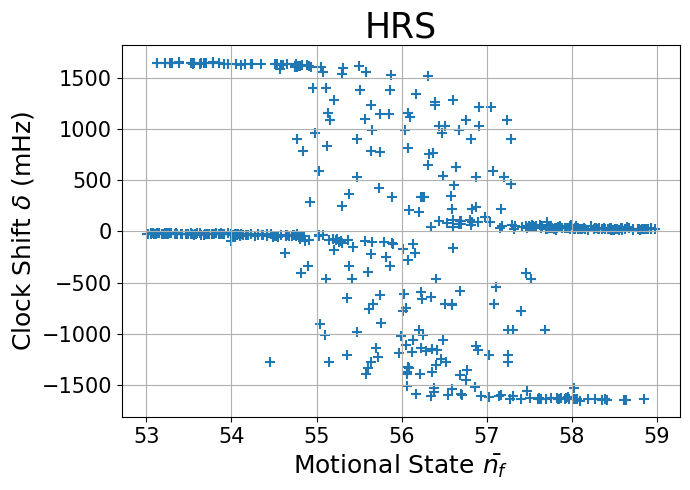

In [50]:
plt.figure(figsize=(7,5), dpi=100)
plt.scatter(nbarfs, results*1e3/(2.0*np.pi),marker="+",s=50)
plt.title("HRS",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
#plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
#plt.xlim([0,58])
#plt.ylim([-100,0])
plt.show()